# Selección clonal para optimización continua

### Descripción

<font size="4"> Algoritmo de selección clonal para resolver un problema de optimización continua (minimización).

---

### Requerimientos

In [1]:
import numpy as np
import copy
import heapq
from scipy.stats import rankdata
from tqdm import tqdm
import matplotlib.pyplot as plt
import landscapes.single_objective as lso

### Parámetros del algoritmo

- $T$: Número de iteraciones
- $N$: Número de células en la población
- $beta$: Factor multiplicativo para el número de clones
- $R$: Número de células aleatorias
- $rho$: Tasa de decaimiento de la mutación
- $random\_state$: Semilla para reproducibilidad

### Definición del problema de optimización
- $L$: Límite inferior de espacio de búsqueda
- $U$: Límite superior de espacio de búsqueda
- $f$: Función objetivo

In [2]:
def Rastrigin():
    n = 20 # Número de variables de decisión  
    L = np.full(n, -5.12)
    U = np.full(n, 5.12)
    f = lso.rastrigin
    return L,U,f

def Sphere():
    n = 10 # Número de variables de decisión  
    L = np.full(n, -5.12)
    U = np.full(n,  5.12)    
    f = lso.sphere
    return L,U,f

def Rosenbrock():
    n = 5 # Número de variables de decisión  
    L = np.full(n, -2.048)
    U = np.full(n, 2.048)
    f = lso.rosenbrock
    return L,U,f

L,U,f = Rastrigin()
# L,U,f = Sphere()
# L,U,f = Rosenbrock()

### Función de afinidad

In [3]:
def A(x,f):
    return -f(x) # La afinidad siempre se maximiza, pero el algoritmo lo hacemos para minimización

### Definición del individuo

In [4]:
class Cell:
    def __init__(self,f,L,U):
        n = L.size
        self.x = [np.random.uniform(L[l],U[l]) for l in range(n)]
        self.A = A(self.x,f)        
    def __lt__(self, ind):
        return self.A < ind.A

### Clonación

In [5]:
def Clones(P,N,beta):
    Q = []    
    Avalues = [c.A for c in P]
    ranking = rankdata(Avalues, method='max')
    for i, c in enumerate(P):
        Nc = int(N*beta / ranking[i])
        for j in range(Nc):
            c2 = copy.deepcopy(c);
            Q.append(c2)
    return Q

### Maduración

In [6]:
def Maturate(P,rho,f,L,U):
    Q = []
    Avalues = [c.A for c in P]
    Amin = min(Avalues)
    Amax = max(Avalues)
    n = L.size
    for c in P:
        c2 = copy.deepcopy(c)
        if Amax>Amin:
            An =  (c.A-Amin)/(Amax-Amin)
        else:
            An = 1
        alpha = (1/rho)*np.exp(-rho*An)
        for l in range(n):
            if np.random.random()<alpha:                
                sigma = alpha*(U[l]-L[l])
                c2.x[l] += np.random.normal(0,sigma)
                c2.x[l] = max(c2.x[l],L[l])
                c2.x[l] = min(c2.x[l],U[l])
                c2.A = A(c2.x,f)
        Q.append(c2)
    return Q

### Progreso del algoritmo

In [7]:
def IniciaProgreso(P,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs,progression_bar)    
    return best_outputs,progression_bar
    
def ActualizaProgreso(P,iter,best_outputs,progression_bar):
    best_fitness = -max(P).A
    progression_bar.set_description("Iteration: %s Fitness: %s " % (str(iter), str(best_fitness)))
    best_outputs[iter] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Algoritmo  de selección clonal

In [8]:
def ClonalSelection(T, N, beta, R, rho, f, L, U, random_state):
    assert T>=1, "El número de iteraciones debe ser mayor o igual que uno."
    assert N>=1, "El número de células en la población debe ser mayor o igual que uno."
    assert beta>0, "El número máximo de clones para cada célula debe ser mayor que cero."
    assert R>=1, "El número de células aleatorias debe ser mayor o igual que uno."
    assert rho>0, "La tasa de decaimiento de la mutación debe ser mayor que cero."

    np.random.seed(random_state)
    
    # Población inicial con N células
    P = [Cell(f,L,U) for _ in range(N)]
    
    # Evoluciona durante T iteraciones
    best_outputs, progression_bar = IniciaProgreso(P,T)    
    for iter in range(1,T+1):
        B = heapq.nlargest(N,P)
        C = Clones(B,beta,N)   
        O = Maturate(C,rho,f,L,U)
        Q = [Cell(f,L,U) for _ in range(R)]        
        P = heapq.nlargest(N,P+O+Q)
        ActualizaProgreso(P,iter,best_outputs,progression_bar)
    S = max(P)
    return best_outputs, -S.A, S.x        

### Definición del Grid Search

Se van a ajustar los parámetros $\beta$ y $\rho$.

In [9]:
def GridSearchCS(options, n_repeat, T, N, R, L, U):    
    best_score = float('inf')
    best_options = None
    for beta in options['beta']:
        for rho in options['rho']:
            score = np.zeros(n_repeat)
            print("beta:",beta," rho:",rho)
            for i in range(n_repeat):
                _, score[i], _ = ClonalSelection(T, N, beta, R, rho, f, L, U, random_state = i)
            scoreMean = score.mean()
            print("Score Mean: ",scoreMean)
            print("")
            if scoreMean < best_score:
                best_score = scoreMean
                best_options = {'beta': beta, 'rho': rho}
    return best_score, best_options

### Ejecución del Grid Search

In [10]:
options = {'beta': [1,5,10],
           'rho': [0.1,0.5,0.9]}

n_repeat = 3
T = 10
N = 20
R = 10
best_score, best_options = GridSearchCS(options, n_repeat, T, N, R, L, U)

print("BEST:")
print(best_score)
print(best_options)

beta: 1  rho: 0.1


Iteration: 10 Fitness: 265.97160136210664 : : 11it [00:00, 11.22it/s]
Iteration: 10 Fitness: 213.7031651819127 : : 11it [00:01,  9.98it/s]
Iteration: 10 Fitness: 267.495123950092 : : 11it [00:00, 11.19it/s]


Score Mean:  249.05663016470376

beta: 1  rho: 0.5


Iteration: 10 Fitness: 265.97160136210664 : : 11it [00:00, 17.32it/s]
Iteration: 10 Fitness: 213.7031651819127 : : 11it [00:00, 17.04it/s]
Iteration: 10 Fitness: 267.495123950092 : : 11it [00:00, 13.49it/s]


Score Mean:  249.05663016470376

beta: 1  rho: 0.9


Iteration: 10 Fitness: 250.44595501002115 : : 11it [00:01, 10.02it/s]
Iteration: 10 Fitness: 271.7966263635366 : : 11it [00:00, 14.24it/s]
Iteration: 10 Fitness: 263.08210361844453 : : 11it [00:00, 18.96it/s]


Score Mean:  261.7748949973341

beta: 5  rho: 0.1


Iteration: 10 Fitness: 275.34038858445723 : : 11it [00:02,  4.82it/s]
Iteration: 10 Fitness: 267.14946534499575 : : 11it [00:01,  5.57it/s]
Iteration: 10 Fitness: 227.033326201778 : : 11it [00:01,  6.87it/s]


Score Mean:  256.5077267104103

beta: 5  rho: 0.5


Iteration: 10 Fitness: 275.34038858445723 : : 11it [00:01,  6.19it/s]
Iteration: 10 Fitness: 267.14946534499575 : : 11it [00:01,  5.85it/s]
Iteration: 10 Fitness: 227.033326201778 : : 11it [00:02,  4.47it/s]


Score Mean:  256.5077267104103

beta: 5  rho: 0.9


Iteration: 10 Fitness: 254.78062005606594 : : 11it [00:02,  4.09it/s]
Iteration: 10 Fitness: 260.5835517475514 : : 11it [00:02,  4.49it/s]
Iteration: 10 Fitness: 200.90920336600755 : : 11it [00:01,  6.72it/s]


Score Mean:  238.75779172320827

beta: 10  rho: 0.1


Iteration: 10 Fitness: 277.17627095571356 : : 11it [00:03,  3.39it/s]
Iteration: 10 Fitness: 252.13580856791094 : : 11it [00:03,  3.62it/s]
Iteration: 10 Fitness: 241.43000516382008 : : 11it [00:02,  3.72it/s]


Score Mean:  256.9140282291482

beta: 10  rho: 0.5


Iteration: 10 Fitness: 277.17627095571356 : : 11it [00:03,  2.98it/s]
Iteration: 10 Fitness: 252.13580856791094 : : 11it [00:04,  2.55it/s]
Iteration: 10 Fitness: 241.43000516382008 : : 11it [00:04,  2.45it/s]


Score Mean:  256.9140282291482

beta: 10  rho: 0.9


Iteration: 10 Fitness: 249.16546670040654 : : 11it [00:09,  1.11it/s]
Iteration: 10 Fitness: 245.0987574925499 : : 11it [00:05,  1.98it/s]
Iteration: 10 Fitness: 207.40330305982727 : : 11it [00:04,  2.49it/s]

Score Mean:  233.88917575092793

BEST:
233.88917575092793
{'beta': 10, 'rho': 0.9}


### Nueva ejecución del CS con los parámetros ajustados

In [11]:
T = 100
N = 100
R = 100
beta = best_options['beta']
rho = best_options['rho']
print("beta:",beta," rho:",rho)
random_state = 1

best_outputs,fitness,x = ClonalSelection(T,N,beta,R,rho,f,L,U,random_state)
print("Mejor solución encontrada x:", x)
print("f(x):", f(x))

beta: 10  rho: 0.9


Iteration: 100 Fitness: 188.45126954543537 : : 101it [04:06,  2.44s/it]

Mejor solución encontrada x: [-0.9678180944598527, 0.1301926136308733, 2.94398164419428, -2.2944232250610765, -2.0651182788747158, 0.7498233702806854, 1.2577944842530744, 1.2668188422325375, 2.825917920016307, -2.221587441566028, -1.916168249759835, 0.07307932428709041, -3.1757196418182536, 5.12, 0.00645006314958696, -0.893043168244942, -0.09448980037974941, 3.9489531305547754, 1.9103821775176595, 1.7459052264297261]
f(x): 188.45126954543537


### Visualización de la evolución del algoritmo

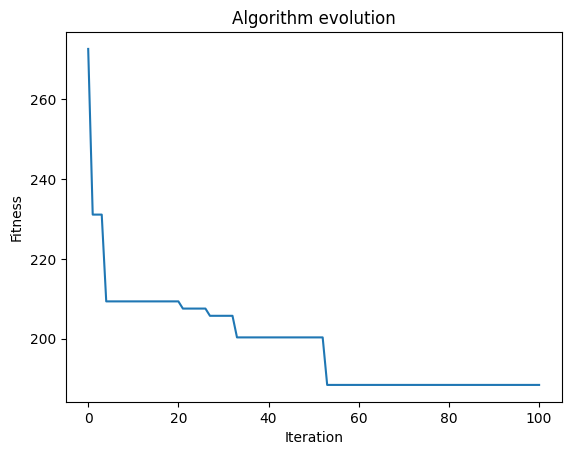

In [12]:
def VisualizaEvolucion(best_outputs):
    fig, ax = plt.subplots()
    ax.set_title("Algorithm evolution")
    plt.plot(best_outputs)
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.show()
    
VisualizaEvolucion(best_outputs)